In [1]:
import pandas as pd
import glob
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# Read in articles

In [2]:
# Read in articles and add country column from filename
def read_articles(filepath):
    data = pd.read_csv(filepath)
    return pd.concat([data.iloc[:,[1,-1]],
                      pd.Series(data.shape[0]*[filepath.split('/')[-1][:2]],name = 'country')
                     ], axis = 1)

In [3]:
# Load in articles
filelist = glob.glob('data/5_domestic_filter_Ngram_stopwords_lemmatize/*')
data = pd.concat([read_articles(k) for k in filelist], axis = 0)
data.columns = ['id', 'text', 'country']
data

,id,text,country
0,16599877,ACCA hold first Virtual Career amp Job Fair Th...,GH
1,18058465,Vindictive Akufo Addo behind Mahama 's EOCO pe...,GH
2,20001894,GCB wipe UT bank logo branch Rebranding head o...,GH
3,19754947,Armyworms defeat yet Suhuyini Farmers Tamale N...,GH
4,20803299,Akufo Addo celebrates legend age J.H Nketia Pr...,GH
...,...,...,...
30690,8260757,South Africa export fruit European market many...,KE
30691,7753188,According Cambridge University report good cho...,KE
30692,7712299,Aggies Fresh establish DMA Solutions Inc. intr...,KE
30693,13659978,In Madurai state Tamil Nadu wholesaler attribu...,KE


### Drop Nulls

In [4]:
print(f'Dropped {data.text.isnull().sum()} rows of blank articles')
x = data[data.text.notnull()].copy().reset_index(drop=True)

Dropped 691 rows of blank articles


## Inspect duplicates

In [5]:
def get_dupes(df, col, headsize = 10):
    duplicates = df[col].value_counts().apply(lambda t: t>1)
    print(df[df[col].apply(lambda ii: duplicates[ii])].sort_values(col).head(headsize))
    return duplicates
    

### Duplicate IDs

In [6]:
#Show duplicate articles sample
get_dupes(x,'id')

#Drop duplicate article IDs
x.drop_duplicates(subset = 'id', inplace = True)
print(f'\n Remaining articles: {x.shape[0]}')

          id                                               text country
129345  5285  Chile becomes sixth country ban Brazilian beef...      GB
97405   5285  Chile becomes sixth country ban Brazilian beef...      GB
122294  5516  Obedience To Authority Should We Trust The Gov...      GB
106145  5516  Obedience To Authority Should We Trust The Gov...      GB
103839  7124  Nathan Eagle Dumb phone future advertising Thi...      GB
119988  7124  Nathan Eagle Dumb phone future advertising Thi...      GB
131669  7394  In 2013 's little people make rock biopic spot...      GB
99729   7394  In 2013 's little people make rock biopic spot...      GB
130555  7502  Talyllyn steam railway Gwynedd asks cash volun...      GB
98615   7502  Talyllyn steam railway Gwynedd asks cash volun...      GB

 Remaining articles: 707799


### Duplicate texts

In [7]:
#There are duplicate articles with different id's
textdupes = get_dupes(x,'text',headsize = 20);
del textdupes

              id                                               text country
667559  81556771  *One Day Access e Edition View available Publi...      US
667551  81987289  *One Day Access e Edition View available Publi...      US
667555  81230309  *One Day Access e Edition View available Publi...      US
667565  84385286  *One Day Access e Edition View available Publi...      US
667567  83341964  *One Day Access e Edition View available Publi...      US
165977  71795449  12 Cases Of COVID 19 Confirmed March 17 2020 W...      JM
165181  71795451  12 Cases Of COVID 19 Confirmed March 17 2020 W...      JM
148298  72099451  2,000 person monitor opening day care entertai...      JM
148341  72109443  2,000 person monitor opening day care entertai...      JM
140352   4721550  2015 Entertainment REWIND James make history b...      JM
146285  10093623  2015 Entertainment REWIND James make history b...      JM
76884   21764135  2019 Obasanjo tell politician general election...      NG
64291   2175

In [8]:
def duplicated_across_feature(df, col1, col2):
    """Checks if there are duplicates in col1 across different features in col2
     For example, col1 could be the text column, col2 the country column, to check if there are text duplicates
     across different countries.
     
     args: 
         df: dataframe
         col1: column to check for duplicates
         col2: feature to count duplicates against
    returns: 
        dataframe giving count of distinct col2 values where duplicate col1 values occur"""
    col1dupe_col2 = df.groupby(col1)[col2].apply(lambda t: t.unique())
    col1dupe_col2.name = col2+'_list'
    col1dupe_col2 = col1dupe_col2.reset_index()
    col1dupe_col2[col2+'_count'] = col1dupe_col2[col2+'_list'].apply(lambda t:len(t))
    return col1dupe_col2

In [9]:
#Only a small amount of text duplicates span multiple countries. I will leave them in each country for now.
textdupe_countrycount = duplicated_across_feature(x,'text','country')
multi_country_dupes = textdupe_countrycount[textdupe_countrycount['country_count'] > 1]
multi_country_dupes
del textdupe_countrycount
del multi_country_dupes

In [10]:
#Drop identical text from same country, but keep duplicates across countries
x = x.drop_duplicates(subset = ['text', 'country'])
x.reset_index(drop=True,inplace=True)
x['text'] = x['text'].str.lower()

#Shows duplicates across countries not dropped
# textdupe_countrycount = duplicated_across_feature(x,'text','country')
# multi_country_dupes = textdupe_countrycount[textdupe_countrycount['country_count'] > 1]
# multi_country_dupes.head()

# del textdupe_countrycount
# del multi_country_dupes

Longest articles:
 301779    329526
305743    137930
450689     82749
410283     59325
309935     38736
309769     34066
309658     30468
185197     29958
462298     25442
462317     24886
309751     24249
309740     24050
24147      22941
410258     22122
462310     21201
Name: text, dtype: int64

 Average article length: 365.584525261485


<AxesSubplot: >

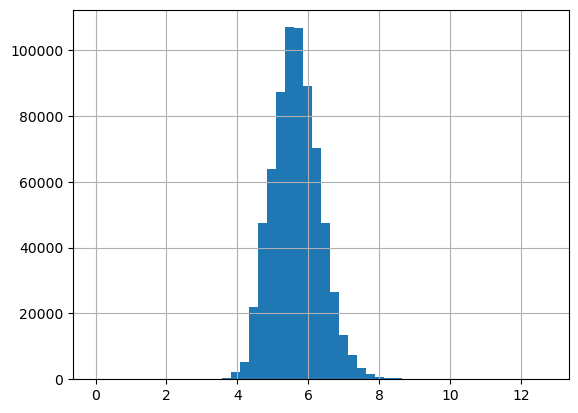

In [11]:
lengths = x.text.apply(lambda x: len(x.split()))
print('Longest articles:\n', lengths.sort_values(ascending=False).head(15))
print(f'\n Average article length: {lengths.mean()}')
np.log(lengths).hist(bins=50)

# Create Count Vectors & Vocabulary

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

In [13]:
countv = CountVectorizer()
cv_text = countv.fit_transform(x.text)
vocab_swap = {v: k for k, v in countv.vocabulary_.items()}

#Sample encodings
print(list(countv.vocabulary_.keys())[:10])
print(list(countv.vocabulary_.values())[:10])

print(f'Observations: {cv_text.shape[0]}')
print(f'Vocab size: {cv_text.shape[1]}')

['acca', 'hold', 'first', 'virtual', 'career', 'amp', 'job', 'fair', 'the', 'objective']
[87897, 532386, 438097, 1231671, 253747, 124992, 597885, 423265, 1150304, 843647]
Observations: 703482
Vocab size: 1289877


In [14]:
#Extract labels and delete copy of text data
labels = x.country
del x

In [15]:
#Encode country codes as numerical labels
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
labels_enc = enc.fit_transform(labels)
print(f'Shape of encoded labels: {labels_enc.shape}')

#Create sparse matrix of encoded labels
from scipy.sparse import hstack, vstack
from scipy.sparse import csr_matrix

labels_enc = csr_matrix(labels_enc).reshape(-1,1)
print(f'Shape of encoded labels (CSR): {labels_enc.shape}')
print(f'Shape of count vectorized text data: {cv_text.shape}')

Shape of encoded labels: (703482,)
Shape of encoded labels (CSR): (703482, 1)
Shape of count vectorized text data: (703482, 1289877)


In [16]:
#Create labeled count vectorized dataset from original as sparse matrix
xy = hstack([cv_text,labels_enc])
xy = xy.tocsr()
del cv_text

# Create Country-Aggregated Dataset

In [17]:
import scipy.sparse as sp

#Get rows of mat whose last column == lab
get_rows = lambda mat, lab: sp.find(mat[:,-1] == lab)[0]

#Sum all rows of a matrix from the list of indices
sum_indices = lambda mat, indices: vstack([mat.getrow(index) for index in indices]).sum(axis = 0)

In [18]:
# Sum all count vectors from each article by country
# Gives count vectors which represent totals accross all articles in the country
 

country_labs = np.unique(np.array(labels_enc.todense()).reshape(-1))
country_vectors = dict()
#XXX Create new functions so that it only has to loop through matrix once, instead of for each label
#Still keep original functions, as will be useful for, e.g. bootstrapping
for lab in country_labs:
    country_vectors[lab] = np.array(sum_indices(xy[:,:-1],get_rows(xy,lab))).reshape(-1)
country_vectors = pd.DataFrame(country_vectors).T

/var/folders/g3/v_62hrbj20d1z2xt6c246v780000gn/T/ipykernel_61322/581631751.py:6: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
  country_vectors[lab] = np.array(sum_indices(xy[:,:-1],get_rows(xy,lab))).reshape(-1)


## Create bootstrapped dataset

## Check distribution of article counts

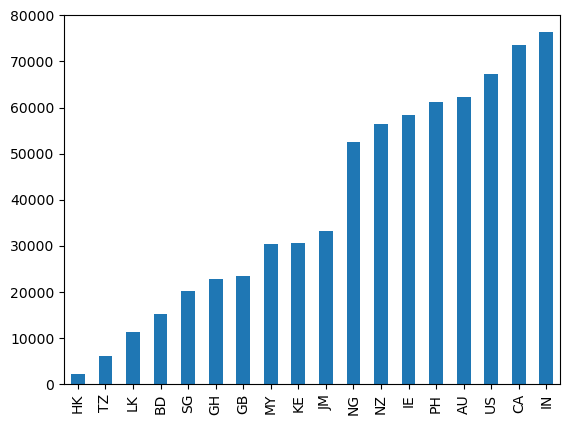

In [19]:
labels.value_counts().sort_values().plot(kind='bar')
plt.show()

# Tfidf

In [34]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import Normalizer

In [35]:
tfidf = TfidfTransformer() #initialize vectorizer
norm = Normalizer()
x_countries = tfidf.fit_transform(country_vectors) #encode text
x_countries = norm.fit_transform(x_countries)

In [36]:
print(f'Shape of x: {x_countries.shape}')

#lots of nonsense; probably want to drop low-count words 
print('Sample vocab:',countv.get_feature_names_out()[300000:300020])

Shape of x: (18, 1289877)
Sample vocab: ['companyspeak' 'companysunday' 'companythat' 'companythe' 'companytheir'
 'companythronged' 'companytoday' 'companytugo' 'companytwo' 'companyuac'
 'companywants' 'companywas' 'companywe' 'companywell' 'companywhich'
 'companywide' 'companywill' 'companywould' 'compaoare' 'compaor']


# Import peace labels

In [23]:
import PyPDF2
import re

with open('power-of-peace-speech/README.md') as f:
    text = f.read()
    
peacetable = ''.join(text.split('\n')[34:46]).split('||')
peacetable = [k.split('|') for k in peacetable]
peacetable[0], peacetable[-1] = peacetable[0][1:], peacetable[-1][:-1]
peacetable = np.array(peacetable)

#Extracts abbreviations from a column
extract_abbvs = lambda column: [re.search(r'\((..)\)',k.strip()).group(1) for k in column 
                                if re.search(r'\((..)\)',k.strip())]

peaceful = extract_abbvs(peacetable[:,0])
nonpeaceful = extract_abbvs(peacetable[:,1])
neutral = extract_abbvs(peacetable[:,2])

print(peaceful)
print(nonpeaceful)
print(neutral)

['AU', 'CA', 'IE', 'NZ', 'SG', 'GB']
['BD', 'KE', 'NG', 'PK', 'TZ']
['GH', 'HK', 'IN', 'JM', 'MY', 'ZA', 'PH', 'LK', 'US']


## Create labeled datasets

In [24]:
peace_indexer = lambda x: -1 if x in nonpeaceful else 1 if x in peaceful else 0
peace_labs = labels.apply(peace_indexer)
peace_country_labs = np.vectorize(peace_indexer)(enc.classes_)

In [25]:
#Create dataset of only high/low peace countries for country dataset
xy_countries = pd.concat([pd.DataFrame(x_countries.todense()),pd.Series(peace_country_labs, name = 'peace_label')],axis = 1)
xy_countries_hl = xy_countries[xy_countries.peace_label != 0]
x_countries_hl = xy_countries_hl.drop('peace_label', axis = 1)
y_countries_hl = xy_countries_hl['peace_label']

### No longer using the table from this file

In [26]:
# pdf = PyPDF2.PdfReader('Peace-Speech-Project-Git/PeaceIndex/Highpeace-lowpeace.pdf')
# table = pdf.pages[1].extract_text()
# items = table[re.search('Table 3', table).span()[1]+1:]\
#         .strip().split('\n')
# p_index = pd.DataFrame(np.array(items[6:]).reshape(-1,7)[:,[0,-1]],
#                       columns = ['Country', 'Peace'])

In [27]:
# country_conversion = pd.read_csv('Peace-Speech-Project-Git/XLNet_News/preprocessing/country_converter_/country_data.tsv',
#                                  sep = '\t')
# country_conversion[['name_short', 'name_official', 'ISO2']]

In [28]:
# abbv = lambda name: country_conversion[country_conversion.name_short == name].ISO2.values[0]
# unabbv = lambda abv: country_conversion[country_conversion.ISO2 == abv].name_short.values[0]

In [29]:
# abbv('United Kingdom')

In [ ]:
# p_index.at[7,'Country'] = 'United Kingdom'
# p_index.at[15,'Country'] = 'Poland'
# p_index.at[17,'Country'] = 'Mexico'

# Random Forest

## HL Country Dataset

In [37]:
#Using the leave-one-out training

#Create classifier
from sklearn.ensemble import RandomForestClassifier
rf_country_hl = RandomForestClassifier()

#Leave-one-out training and predictions
country_labels = list()
peace_preds = list()
for row in x_countries_hl.index:
    rf_country_hl.fit(x_countries_hl.drop(row,axis = 0).values,y_countries_hl.drop(row,axis = 0).values)
    country_labels.append(row)
    peace_preds.append(rf_country_hl.predict(x_countries_hl.loc[row].values.reshape(1,-1))[0])
    
results = pd.DataFrame({'country_label':country_labels, 'peace_preds':peace_preds})
results = pd.concat([results.set_index('country_label'),y_countries_hl], axis = 1)
results['pred_correct'] = results.peace_preds == results.peace_label

get_country_abbv_out = lambda x: enc.classes_[x]
results.index = np.vectorize(get_country_abbv_out)(results.index)
results

,peace_preds,peace_label,pred_correct
AU,1,1,True
BD,1,-1,False
CA,1,1,True
GB,1,1,True
IE,1,1,True
KE,-1,-1,True
NG,1,-1,False
NZ,1,1,True
SG,-1,1,False
TZ,-1,-1,True


In [38]:
#Just to get importances -- though will be overfit as no holdout
rf_country_hl.fit(x_countries_hl.values,y_countries_hl.values)

#Clearly overfit with 100% accuracy
preds = rf_country_hl.predict(x_countries_hl.values)
results = pd.DataFrame({'peace_preds':preds, 'peace_label': y_countries_hl.values},
             index = np.vectorize(get_country_abbv_out)(x_countries_hl.index))
results['pred_correct'] = results.peace_preds == results.peace_label
results

,peace_preds,peace_label,pred_correct
AU,1,1,True
BD,-1,-1,True
CA,1,1,True
GB,1,1,True
IE,1,1,True
KE,-1,-1,True
NG,-1,-1,True
NZ,1,1,True
SG,1,1,True
TZ,-1,-1,True


In [39]:
importances = pd.DataFrame({'word_index':x_countries_hl.columns, 'importance':rf_country_hl.feature_importances_})
importances['word'] = importances.word_index.apply(lambda k: vocab_swap[k])

#Also mostly nonsense -- could be that instances of nonce words too strongly identify certain country origins,
#hence it can memorize the countries
importances.sort_values('importance', ascending=False).head(30)

,word_index,importance,word
1240273,1240273,0.01,wakelin
823955,823955,0.01,nishu
732953,732953,0.01,mayweather
339175,339175,0.01,declutter
693156,693156,0.01,loud
406272,406272,0.01,epsom
1160064,1160064,0.01,tiar
987759,987759,0.01,revlon
767540,767540,0.01,mollema
86955,86955,0.01,absu


## HL Boostrapped Dataset